In [1]:
import sys
import math
import numpy as np
import pandas as pd
import random
from sklearn import svm
from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing
import brute_force_classifier as bfc
import brute_force_regressor as bfr
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ShuffleSplit, train_test_split, cross_val_score
import matplotlib.pyplot as plt
from scipy import stats
from scipy import special
import seaborn as sns
sns.set()
# settings
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
#check that our features are consistent between the Test and Train
train_test_intersection = np.intersect1d(train.columns, test.columns)
print('Similar Features')
print (train_test_intersection)
train_test_difference = np.setdiff1d(train.columns, test.columns)

print('Different Features')
print (train_test_difference)

Similar Features
['1stFlrSF' '2ndFlrSF' '3SsnPorch' 'Alley' 'BedroomAbvGr' 'BldgType'
 'BsmtCond' 'BsmtExposure' 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtFinType1'
 'BsmtFinType2' 'BsmtFullBath' 'BsmtHalfBath' 'BsmtQual' 'BsmtUnfSF'
 'CentralAir' 'Condition1' 'Condition2' 'Electrical' 'EnclosedPorch'
 'ExterCond' 'ExterQual' 'Exterior1st' 'Exterior2nd' 'Fence' 'FireplaceQu'
 'Fireplaces' 'Foundation' 'FullBath' 'Functional' 'GarageArea'
 'GarageCars' 'GarageCond' 'GarageFinish' 'GarageQual' 'GarageType'
 'GarageYrBlt' 'GrLivArea' 'HalfBath' 'Heating' 'HeatingQC' 'HouseStyle'
 'Id' 'KitchenAbvGr' 'KitchenQual' 'LandContour' 'LandSlope' 'LotArea'
 'LotConfig' 'LotFrontage' 'LotShape' 'LowQualFinSF' 'MSSubClass'
 'MSZoning' 'MasVnrArea' 'MasVnrType' 'MiscFeature' 'MiscVal' 'MoSold'
 'Neighborhood' 'OpenPorchSF' 'OverallCond' 'OverallQual' 'PavedDrive'
 'PoolArea' 'PoolQC' 'RoofMatl' 'RoofStyle' 'SaleCondition' 'SaleType'
 'ScreenPorch' 'Street' 'TotRmsAbvGrd' 'TotalBsmtSF' 'Utilities'
 'WoodDeckSF'

In [4]:
# Features are consistent between Test and Train. since this is a small data set let's just concate them together and perform 
# our preprocessing on the combined dataset
all_data = train.append(test,ignore_index=True)
features = pd.DataFrame()

In [5]:
#see what features we have missing data for. We will handle each feature on an individual basis
missing_data = all_data.isnull().sum()
missing_data = missing_data[missing_data.ge(1)]
print(missing_data)

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
SalePrice       1459
dtype: int64


Skewness: 1.883
Kurtosis: 6.536


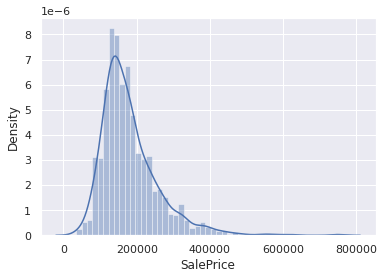

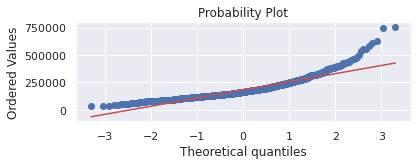

In [6]:
#visualize the SalePrice which we will predict
sns.distplot(train['SalePrice'])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train['SalePrice'], dist=stats.norm, plot=ax)
print(f"Skewness: {train['SalePrice'].skew():.3f}")
print(f"Kurtosis: {train['SalePrice'].kurt():.3f}")

Box-Cox Lambda: -0.077
Skewness: -0.009
Kurtosis: 0.878


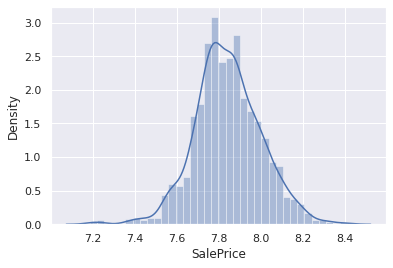

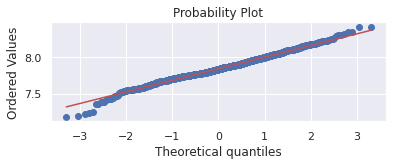

In [7]:
# applying box-cox transformation to improve normality
train['SalePrice'], SalePrice_lamb = stats.boxcox(train['SalePrice'])

sns.distplot(train['SalePrice'])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train['SalePrice'], dist=stats.norm, plot=ax)
print(f"Box-Cox Lambda: {SalePrice_lamb:.3f}")
print(f"Skewness: {train['SalePrice'].skew():.3f}")
print(f"Kurtosis: {train['SalePrice'].kurt():.3f}")

Skewness: -0.009
Kurtosis: 0.878


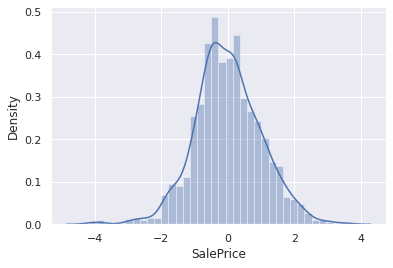

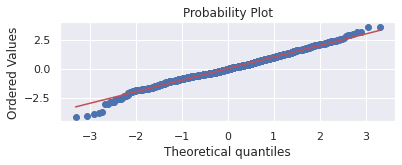

In [8]:
# apply standard scalar to Sales prices and store in labels
labels_scaler = preprocessing.StandardScaler().fit(train[['SalePrice']])
train['SalePrice'] = labels_scaler.transform(train[['SalePrice']])
Y = train['SalePrice']

sns.distplot(train['SalePrice'])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train['SalePrice'], dist=stats.norm, plot=ax)
print(f"Skewness: {train['SalePrice'].skew():.3f}")
print(f"Kurtosis: {train['SalePrice'].kurt():.3f}")

In [9]:
# MSSubClass: Identifies the type of dwelling involved in the sale.	

#         20	1-STORY 1946 & NEWER ALL STYLES
#         30	1-STORY 1945 & OLDER
#         40	1-STORY W/FINISHED ATTIC ALL AGES
#         45	1-1/2 STORY - UNFINISHED ALL AGES
#         50	1-1/2 STORY FINISHED ALL AGES
#         60	2-STORY 1946 & NEWER
#         70	2-STORY 1945 & OLDER
#         75	2-1/2 STORY ALL AGES
#         80	SPLIT OR MULTI-LEVEL
#         85	SPLIT FOYER
#         90	DUPLEX - ALL STYLES AND AGES
#        120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
#        150	1-1/2 STORY PUD - ALL AGES
#        160	2-STORY PUD - 1946 & NEWER
#        180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
#        190	2 FAMILY CONVERSION - ALL STYLES AND AGES
column = 'MSSubClass'

# let's get dummy value for these classes
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [10]:
# MSZoning: Identifies the general zoning classification of the sale.

#        A	Agriculture
#        C (all)	Commercial
#        FV	Floating Village Residential
#        I	Industrial
#        RH	Residential High Density
#        RL	Residential Low Density
#        RP	Residential Low Density Park 
#        RM	Residential Medium Density
column = 'MSZoning'

# for the 4 missing values assign the most common 'RL'
all_data[column] = all_data[column].fillna('RL')

dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))


# Was going to preprocess by Zoning Area, but It wasn't very effective the Majority of Data is RL so it didn't really matter

# MSZoning_dict = dict()
# MSZoning_dict['A'] = {}
# MSZoning_dict['A']['N'] = len(all_data.loc[all_data['MSZoning'] == 'A'])
# MSZoning_dict['C (all)'] = {}
# MSZoning_dict['C (all)']['N'] = len(all_data.loc[all_data['MSZoning'] == 'C (all)'])
# MSZoning_dict['FV'] = {}
# MSZoning_dict['FV']['N'] = len(all_data.loc[all_data['MSZoning'] == 'FV'])
# MSZoning_dict['I'] = {}
# MSZoning_dict['I']['N'] = len(all_data.loc[all_data['MSZoning'] == 'I'])
# MSZoning_dict['RH'] = {}
# MSZoning_dict['RH']['N'] = len(all_data.loc[all_data['MSZoning'] == 'RH'])
# MSZoning_dict['RL'] = {}
# MSZoning_dict['RL']['N'] = len(all_data.loc[all_data['MSZoning'] == 'RL'])
# MSZoning_dict['RP'] = {}
# MSZoning_dict['RP']['N'] = len(all_data.loc[all_data['MSZoning'] == 'RP'])
# MSZoning_dict['RM'] = {}
# MSZoning_dict['RM']['N'] = len(all_data.loc[all_data['MSZoning'] == 'RM'])

# if print_level < -1:
#     print('Number of Properties for MSZoning')
#     print('A {0}'.format(MSZoning_dict['A']['N']))
#     print('C (all) {0}'.format(MSZoning_dict['C (all)']['N']))
#     print('FV {0}'.format(MSZoning_dict['FV']['N']))
#     print('I {0}'.format(MSZoning_dict['I']['N']))
#     print('RH {0}'.format(MSZoning_dict['RH']['N']))
#     print('RL {0}'.format(MSZoning_dict['RL']['N']))
#     print('RP {0}'.format(MSZoning_dict['RP']['N']))
#     print('RM {0}'.format(MSZoning_dict['RM']['N']))

0 incomplete values


In [11]:
# A Standard Scalar function processes based off of what zoning the properties were. Was slightly less effective than treating all data the same

# def ZoneStandardScalar(column):
#     column_mean = column + '_Mean'
#     column_std = column + 'Std'

#     # get the average LotFrontage for each MSZoning and fill in missing values accordingly
#     MSZoning_dict['A'][column_mean] = all_data[column].loc[all_data['MSZoning'] == 'A'].mean()
#     MSZoning_dict['C (all)'][column_mean] = all_data[column].loc[all_data['MSZoning'] == 'C (all)'].mean()
#     MSZoning_dict['FV'][column_mean] = all_data[column].loc[all_data['MSZoning'] == 'FV'].mean()
#     MSZoning_dict['I'][column_mean] = all_data[column].loc[all_data['MSZoning'] == 'I'].mean()
#     MSZoning_dict['RH'][column_mean] = all_data[column].loc[all_data['MSZoning'] == 'RH'].mean()
#     MSZoning_dict['RL'][column_mean] = all_data[column].loc[all_data['MSZoning'] == 'RL'].mean()
#     MSZoning_dict['RP'][column_mean] = all_data[column].loc[all_data['MSZoning'] == 'RP'].mean()
#     MSZoning_dict['RM'][column_mean] = all_data[column].loc[all_data['MSZoning'] == 'RM'].mean()

#     MSZoning_dict['A'][column_std] = all_data[column].loc[all_data['MSZoning'] == 'A'].std()
#     MSZoning_dict['C (all)'][column_std] = all_data[column].loc[all_data['MSZoning'] == 'C (all)'].std()
#     MSZoning_dict['FV'][column_std] = all_data[column].loc[all_data['MSZoning'] == 'FV'].std()
#     MSZoning_dict['I'][column_std] = all_data[column].loc[all_data['MSZoning'] == 'I'].std()
#     MSZoning_dict['RH'][column_std] = all_data[column].loc[all_data['MSZoning'] == 'RH'].std()
#     MSZoning_dict['RL'][column_std] = all_data[column].loc[all_data['MSZoning'] == 'RL'].std()
#     MSZoning_dict['RP'][column_std] = all_data[column].loc[all_data['MSZoning'] == 'RP'].std()
#     MSZoning_dict['RM'][column_std] = all_data[column].loc[all_data['MSZoning'] == 'RM'].std()


#     if print_level < -1:
#         print('Mean LotFrontage by MSZoning')
#         print('A {0} std {2} n properties {1}'.format(MSZoning_dict['A'][column_mean],MSZoning_dict['A']['N'],MSZoning_dict['A'][column_std]))
#         print('C (all) {0} std {2} n properties {1}'.format(MSZoning_dict['C (all)'][column_mean],MSZoning_dict['C (all)']['N'],MSZoning_dict['C (all)'][column_std]))
#         print('FV {0} std {2} n properties {1}'.format(MSZoning_dict['FV'][column_mean],MSZoning_dict['FV']['N'],MSZoning_dict['FV'][column_std]))
#         print('I {0} std {2} n properties {1}'.format(MSZoning_dict['I'][column_mean],MSZoning_dict['I']['N'],MSZoning_dict['I'][column_std]))
#         print('RH {0} std {2} n properties {1}'.format(MSZoning_dict['RH'][column_mean],MSZoning_dict['RH']['N'],MSZoning_dict['RH'][column_std]))
#         print('RL {0} std {2} n properties {1}'.format(MSZoning_dict['RL'][column_mean],MSZoning_dict['RL']['N'],MSZoning_dict['RL'][column_std]))
#         print('RP {0} std {2} n properties {1}'.format(MSZoning_dict['RP'][column_mean],MSZoning_dict['RP']['N'],MSZoning_dict['RP'][column_std]))
#         print('RM {0} std {2} n properties {1}'.format(MSZoning_dict['RM'][column_mean],MSZoning_dict['RM']['N'],MSZoning_dict['RM'][column_std]))
#         print()
        
#     # Perform a standard scalar for each type of MSZoning
#     MSZoning = ['A','C (all)','FV','I','RH','RL','RP','RM']
#     for zone in MSZoning:
#         #fill Nan with the mean
#         all_data.loc[(all_data.MSZoning == zone),column] = all_data.loc[(all_data.MSZoning == zone),column].fillna(MSZoning_dict[zone][column_mean])
#         #set mean to 0
#         all_data.loc[(all_data.MSZoning == zone),column] -= MSZoning_dict[zone][column_mean]
#         #set unit variance
#         all_data.loc[(all_data.MSZoning == zone),column] /= MSZoning_dict[zone][column_std]

#     MSZoning_dict['A'][column_mean] = all_data[column].loc[all_data['MSZoning'] == 'A'].mean()
#     MSZoning_dict['C (all)'][column_mean] = all_data[column].loc[all_data['MSZoning'] == 'C (all)'].mean()
#     MSZoning_dict['FV'][column_mean] = all_data[column].loc[all_data['MSZoning'] == 'FV'].mean()
#     MSZoning_dict['I'][column_mean] = all_data[column].loc[all_data['MSZoning'] == 'I'].mean()
#     MSZoning_dict['RH'][column_mean] = all_data[column].loc[all_data['MSZoning'] == 'RH'].mean()
#     MSZoning_dict['RL'][column_mean] = all_data[column].loc[all_data['MSZoning'] == 'RL'].mean()
#     MSZoning_dict['RP'][column_mean] = all_data[column].loc[all_data['MSZoning'] == 'RP'].mean()
#     MSZoning_dict['RM'][column_mean] = all_data[column].loc[all_data['MSZoning'] == 'RM'].mean()

#     MSZoning_dict['A'][column_std] = all_data[column].loc[all_data['MSZoning'] == 'A'].std()
#     MSZoning_dict['C (all)'][column_std] = all_data[column].loc[all_data['MSZoning'] == 'C (all)'].std()
#     MSZoning_dict['FV'][column_std] = all_data[column].loc[all_data['MSZoning'] == 'FV'].std()
#     MSZoning_dict['I'][column_std] = all_data[column].loc[all_data['MSZoning'] == 'I'].std()
#     MSZoning_dict['RH'][column_std] = all_data[column].loc[all_data['MSZoning'] == 'RH'].std()
#     MSZoning_dict['RL'][column_std] = all_data[column].loc[all_data['MSZoning'] == 'RL'].std()
#     MSZoning_dict['RP'][column_std] = all_data[column].loc[all_data['MSZoning'] == 'RP'].std()
#     MSZoning_dict['RM'][column_std] = all_data[column].loc[all_data['MSZoning'] == 'RM'].std()

#     if print_level < -1:
#         print('Mean LotFrontage by MSZoning')
#         print('A {0} std {2} n properties {1}'.format(MSZoning_dict['A'][column_mean],MSZoning_dict['A']['N'],MSZoning_dict['A'][column_std]))
#         print('C (all) {0} std {2} n properties {1}'.format(MSZoning_dict['C (all)'][column_mean],MSZoning_dict['C (all)']['N'],MSZoning_dict['C (all)'][column_std]))
#         print('FV {0} std {2} n properties {1}'.format(MSZoning_dict['FV'][column_mean],MSZoning_dict['FV']['N'],MSZoning_dict['FV'][column_std]))
#         print('I {0} std {2} n properties {1}'.format(MSZoning_dict['I'][column_mean],MSZoning_dict['I']['N'],MSZoning_dict['I'][column_std]))
#         print('RH {0} std {2} n properties {1}'.format(MSZoning_dict['RH'][column_mean],MSZoning_dict['RH']['N'],MSZoning_dict['RH'][column_std]))
#         print('RL {0} std {2} n properties {1}'.format(MSZoning_dict['RL'][column_mean],MSZoning_dict['RL']['N'],MSZoning_dict['RL'][column_std]))
#         print('RP {0} std {2} n properties {1}'.format(MSZoning_dict['RP'][column_mean],MSZoning_dict['RP']['N'],MSZoning_dict['RP'][column_std]))
#         print('RM {0} std {2} n properties {1}'.format(MSZoning_dict['RM'][column_mean],MSZoning_dict['RM']['N'],MSZoning_dict['RM'][column_std]))

In [12]:
# LotFrontage: Linear feet of street connected to property
column = 'LotFrontage'

# Let's drop this feature here
# Reason 1 Far too many missing values
# Reason 2 colinarity with LotArea

# all_data[column] = all_data[column].fillna(all_data[column].mean())
# all_data.loc[(all_data[column]>0),column] = np.log(all_data[column])
# scaler = preprocessing.StandardScaler().fit(all_data[[column]])
# all_data[[column]] = scaler.transform(all_data[[column]])
# features = pd.concat([features,all_data[column]],axis=1)
# print('{0} incomplete values'.format(all_data[column].isnull().sum()))

Skewness: 12.829
Kurtosis: 264.952


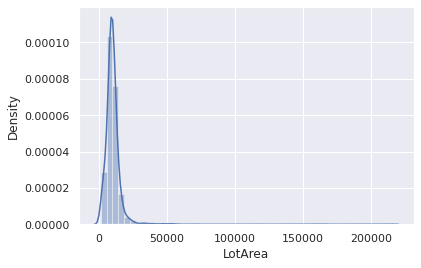

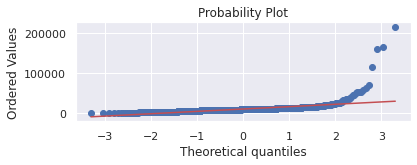

In [13]:
# LotArea: Lot size in square feet
column = 'LotArea'

sns.distplot(all_data[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)
print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")

Skewness: 0.104
Kurtosis: 5.308
0 incomplete values


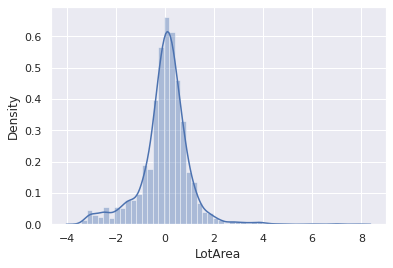

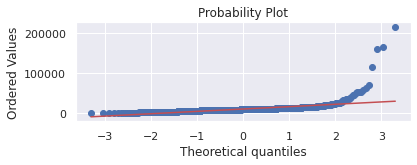

In [14]:
# LotArea: Lot size in square feet
column = 'LotArea'

# box-cox to improve normaility
all_data[column], lamb = stats.boxcox(all_data[column])
scaler = preprocessing.StandardScaler().fit(all_data[[column]])
all_data[[column]] = scaler.transform(all_data[[column]])
features = pd.concat([features,all_data[column]],axis=1)

sns.distplot(all_data[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)

print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

In [15]:
# Street: Type of road access to property

#        Grvl	Gravel	
#        Pave	Paved
column = 'Street'

# apply dummy values
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [16]:
# Alley: Type of alley access to property

#        Grvl	Gravel
#        Pave	Paved
#        NA 	No alley access
column = 'Alley'

# apply dummy values an fill Nan with NA
all_data[column] = all_data[column].fillna('NA')
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [17]:
# LotShape: General shape of property

#        Reg	Regular	
#        IR1	Slightly irregular
#        IR2	Moderately Irregular
#        IR3	Irregular
column = 'LotShape'

# apply dummy values
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [18]:
# LandContour: Flatness of the property

#        Lvl	Near Flat/Level	
#        Bnk	Banked - Quick and significant rise from street grade to building
#        HLS	Hillside - Significant slope from side to side
#        Low	Depression
column = 'LandContour'

# apply dummy values
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [19]:
# Utilities: Type of utilities available
		
#        AllPub	All public Utilities (E,G,W,& S)	
#        NoSewr	Electricity, Gas, and Water (Septic Tank)
#        NoSeWa	Electricity and Gas Only
#        ELO	Electricity only	
column = 'Utilities'

# 2 samples are Nan assume All Public utilites and apply dummy values
all_data[column] = all_data[column].fillna('AllPub')
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [20]:
# LotConfig: Lot configuration

#        Inside	Inside lot
#        Corner	Corner lot
#        CulDSac	Cul-de-sac
#        FR2	Frontage on 2 sides of property
#        FR3	Frontage on 3 sides of property
column = 'LotConfig'

# apply dummy values
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [21]:
# LandSlope: Slope of property
		
#        Gtl	Gentle slope
#        Mod	Moderate Slope	
#        Sev	Severe Slope
column = 'LandSlope'

# apply dummy values
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [22]:
# Neighborhood: Physical locations within Ames city limits

#        Blmngtn	Bloomington Heights
#        Blueste	Bluestem
#        BrDale	Briardale
#        BrkSide	Brookside
#        ClearCr	Clear Creek
#        CollgCr	College Creek
#        Crawfor	Crawford
#        Edwards	Edwards
#        Gilbert	Gilbert
#        IDOTRR	Iowa DOT and Rail Road
#        MeadowV	Meadow Village
#        Mitchel	Mitchell
#        Names	North Ames
#        NoRidge	Northridge
#        NPkVill	Northpark Villa
#        NridgHt	Northridge Heights
#        NWAmes	Northwest Ames
#        OldTown	Old Town
#        SWISU	South & West of Iowa State University
#        Sawyer	Sawyer
#        SawyerW	Sawyer West
#        Somerst	Somerset
#        StoneBr	Stone Brook
#        Timber	Timberland
#        Veenker	Veenker
column = 'Neighborhood'

# apply dummy values
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [23]:
# Condition1: Proximity to various conditions
	
#        Artery	Adjacent to arterial street
#        Feedr	Adjacent to feeder street	
#        Norm	Normal	
#        RRNn	Within 200' of North-South Railroad
#        RRAn	Adjacent to North-South Railroad
#        PosN	Near positive off-site feature--park, greenbelt, etc.
#        PosA	Adjacent to postive off-site feature
#        RRNe	Within 200' of East-West Railroad
#        RRAe	Adjacent to East-West Railroad
column = 'Condition1'

# apply dummy values
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [24]:
# Condition2: Proximity to various conditions (if more than one is present)
		
#        Artery	Adjacent to arterial street
#        Feedr	Adjacent to feeder street	
#        Norm	Normal	
#        RRNn	Within 200' of North-South Railroad
#        RRAn	Adjacent to North-South Railroad
#        PosN	Near positive off-site feature--park, greenbelt, etc.
#        PosA	Adjacent to postive off-site feature
#        RRNe	Within 200' of East-West Railroad
#        RRAe	Adjacent to East-West Railroad
column = 'Condition2'

# apply dummy values
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [25]:
# BldgType: Type of dwelling
		
#        1Fam	Single-family Detached	
#        2FmCon	Two-family Conversion; originally built as one-family dwelling
#        Duplx	Duplex
#        TwnhsE	Townhouse End Unit
#        TwnhsI	Townhouse Inside Unit
column = 'BldgType'

# apply dummy values
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [26]:
# HouseStyle: Style of dwelling
	
#        1Story	One story
#        1.5Fin	One and one-half story: 2nd level finished
#        1.5Unf	One and one-half story: 2nd level unfinished
#        2Story	Two story
#        2.5Fin	Two and one-half story: 2nd level finished
#        2.5Unf	Two and one-half story: 2nd level unfinished
#        SFoyer	Split Foyer
#        SLvl	Split Level
column = 'HouseStyle'

# apply dummy values
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


Skewness: 0.197
Kurtosis: 0.067


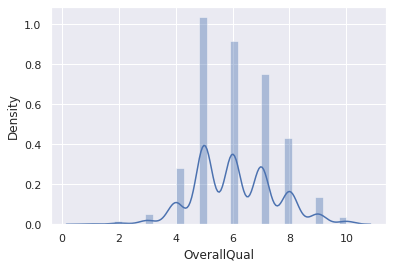

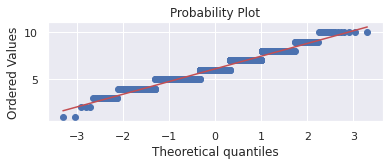

In [27]:
# OverallQual: Rates the overall material and finish of the house

#        10	Very Excellent
#        9	Excellent
#        8	Very Good
#        7	Good
#        6	Above Average
#        5	Average
#        4	Below Average
#        3	Fair
#        2	Poor
#        1	Very Poor
column = 'OverallQual'

sns.distplot(all_data[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)

print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")

Skewness: 0.030
Kurtosis: 0.232
0 incomplete values


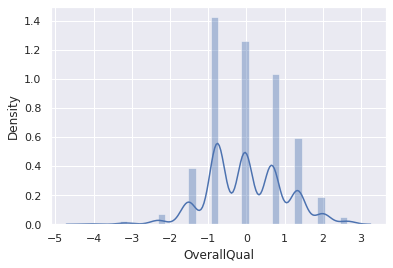

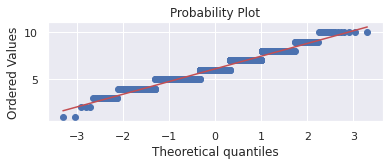

In [28]:
column = 'OverallQual'

# box-cox to improve normaility
all_data[column], lamb = stats.boxcox(all_data[column])
scaler = preprocessing.StandardScaler().fit(all_data[[column]])
all_data[[column]] = scaler.transform(all_data[[column]])
features = pd.concat([features,all_data[column]],axis=1)

sns.distplot(all_data[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)

print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

Skewness: 0.571
Kurtosis: 1.479


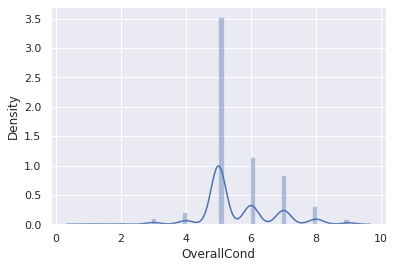

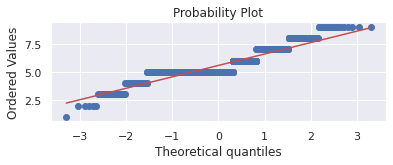

In [29]:
# OverallCond: Rates the overall condition of the house

#        10	Very Excellent
#        9	Excellent
#        8	Very Good
#        7	Good
#        6	Above Average	
#        5	Average
#        4	Below Average	
#        3	Fair
#        2	Poor
#        1	Very Poor
column = 'OverallCond'

sns.distplot(all_data[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)

print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")

Skewness: 0.144
Kurtosis: 2.355
0 incomplete values


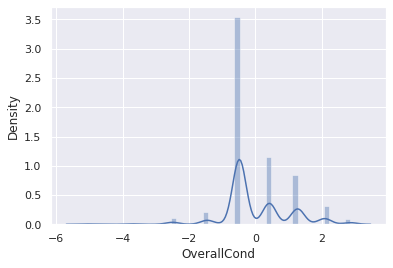

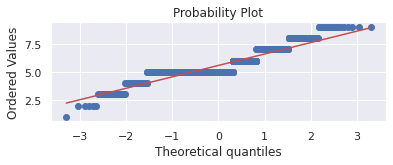

In [30]:
column = 'OverallCond'

# box-cox to improve normaility
all_data[column], lamb = stats.boxcox(all_data[column])
scaler = preprocessing.StandardScaler().fit(all_data[[column]])
all_data[[column]] = scaler.transform(all_data[[column]])
features = pd.concat([features,all_data[column]],axis=1)

sns.distplot(all_data[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)

print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

Skewness: -0.600
Kurtosis: -0.511


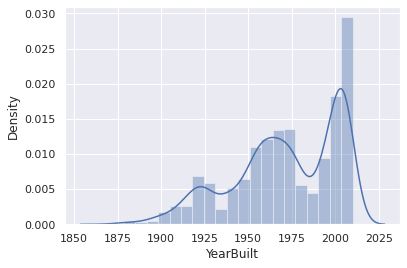

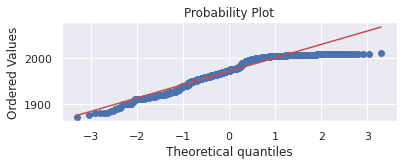

In [31]:
# YearBuilt: Original construction date
column = 'YearBuilt'

sns.distplot(all_data[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)

print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")

Skewness: -0.600
Kurtosis: -0.511
0 incomplete values


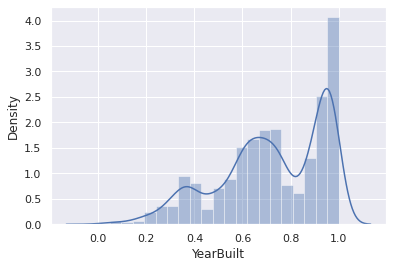

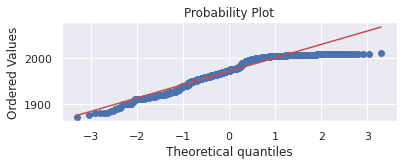

In [32]:
column = 'YearBuilt'

#use min-max scaling
all_data[column] = (all_data[column] - all_data[column].min()) / (all_data[column].max() - all_data[column].min())
features = pd.concat([features,all_data[column]],axis=1)
sns.distplot(all_data[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)

print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

Skewness: -0.451
Kurtosis: -1.346
0 incomplete values


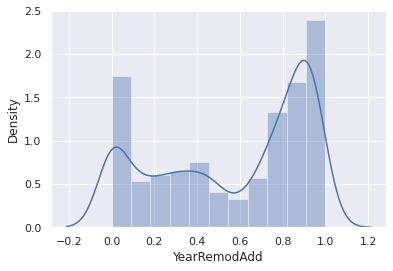

In [33]:
# YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)
column = 'YearRemodAdd'

#use min-max scaling
all_data[column] = (all_data[column] - all_data[column].min()) / (all_data[column].max() - all_data[column].min())
features = pd.concat([features,all_data[column]],axis=1)
sns.distplot(all_data[column])
print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

In [34]:
# RoofStyle: Type of roof

#        Flat	Flat
#        Gable	Gable
#        Gambrel	Gabrel (Barn)
#        Hip	Hip
#        Mansard	Mansard
#        Shed	Shed
column = 'RoofStyle'

# apply dummy values
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [35]:
# RoofMatl: Roof material

#        ClyTile	Clay or Tile
#        CompShg	Standard (Composite) Shingle
#        Membran	Membrane
#        Metal	Metal
#        Roll	Roll
#        Tar&Grv	Gravel & Tar
#        WdShake	Wood Shakes
#        WdShngl	Wood Shingles
column = 'RoofMatl'

# apply dummy values
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [36]:
# Exterior1st: Exterior covering on house

#        AsbShng	Asbestos Shingles
#        AsphShn	Asphalt Shingles
#        BrkComm	Brick Common
#        BrkFace	Brick Face
#        CBlock	Cinder Block
#        CemntBd	Cement Board
#        HdBoard	Hard Board
#        ImStucc	Imitation Stucco
#        MetalSd	Metal Siding
#        Other	Other
#        Plywood	Plywood
#        PreCast	PreCast	
#        Stone	Stone
#        Stucco	Stucco
#        VinylSd	Vinyl Siding
#        Wd Sdng	Wood Siding
#        WdShing	Wood Shingles
column = 'Exterior1st'

# 1 sample has a missing value. replace with 'VinylSd' and apply dummy values
all_data[column] = all_data[column].fillna('VinylSd')
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [37]:
# Exterior2nd: Exterior covering on house (if more than one material)

#        AsbShng	Asbestos Shingles
#        AsphShn	Asphalt Shingles
#        BrkComm	Brick Common
#        BrkFace	Brick Face
#        CBlock	Cinder Block
#        CemntBd	Cement Board
#        HdBoard	Hard Board
#        ImStucc	Imitation Stucco
#        MetalSd	Metal Siding
#        Other	Other
#        Plywood	Plywood
#        PreCast	PreCast
#        Stone	Stone
#        Stucco	Stucco
#        VinylSd	Vinyl Siding
#        Wd Sdng	Wood Siding
#        WdShing	Wood Shingles
column = 'Exterior2nd'

# 1 sample has a missing value. replace with 'VinylSd' and apply dummy values
all_data[column] = all_data[column].fillna('VinylSd')
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [38]:
# MasVnrType: Masonry veneer type

#        BrkCmn	Brick Common
#        BrkFace	Brick Face
#        CBlock	Cinder Block
#        None	None
#        Stone	Stone
column = 'MasVnrType'

# 24 samples have a missing value. replace with 'None' and apply dummy values
all_data[column] = all_data[column].fillna('None')
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


Skewness: 2.615
Kurtosis: 9.336


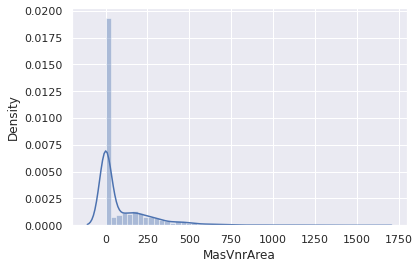

In [39]:
# MasVnrArea: Masonry veneer area in square feet
column = 'MasVnrArea'

all_data[column] = all_data[column].fillna(0)
sns.distplot(all_data[column])
print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")

Skewness: 2.615
Kurtosis: 9.336
0 incomplete values


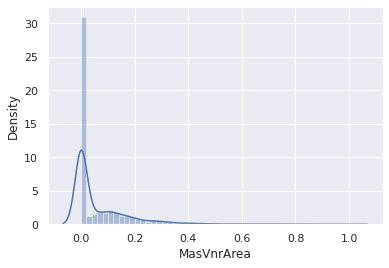

In [40]:
column = 'MasVnrArea'

#use min-max scaling
all_data[column] = (all_data[column] - all_data[column].min()) / (all_data[column].max() - all_data[column].min())
features = pd.concat([features,all_data[column]],axis=1)
sns.distplot(all_data[column])
print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

In [41]:
# ExterQual: Evaluates the quality of the material on the exterior 
		
#        Ex	Excellent
#        Gd	Good
#        TA	Average/Typical
#        Fa	Fair
#        Po	Poor
column = 'ExterQual'

all_data[column] = all_data[column].fillna('TA')
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [42]:
# ExterCond: Evaluates the present condition of the material on the exterior
		
#        Ex	Excellent
#        Gd	Good
#        TA	Average/Typical
#        Fa	Fair
#        Po	Poor
column = 'ExterCond'

# apply dummy values
all_data[column] = all_data[column].fillna('TA')
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [43]:
# Foundation: Type of foundation
		
#        BrkTil	Brick & Tile
#        CBlock	Cinder Block
#        PConc	Poured Contrete	
#        Slab	Slab
#        Stone	Stone
#        Wood	Wood
column = 'Foundation'

# apply dummy values
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [44]:
# BsmtQual: Evaluates the height of the basement

#        Ex	Excellent (100+ inches)	
#        Gd	Good (90-99 inches)
#        TA	Typical (80-89 inches)
#        Fa	Fair (70-79 inches)
#        Po	Poor (<70 inches
#        NA	No Basement
column = 'BsmtQual'

# replace the 81 samples that have missing data with NA and apply dummy values
all_data[column] = all_data[column].fillna('NA')
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [45]:
# BsmtCond: Evaluates the general condition of the basement

#        Ex	Excellent
#        Gd	Good
#        TA	Typical - slight dampness allowed
#        Fa	Fair - dampness or some cracking or settling
#        Po	Poor - Severe cracking, settling, or wetness
#        NA	No Basement
column = 'BsmtCond'

# Now have 82 samples with missing data let's replace missing data with 'BsmtQual'
all_data[column] = all_data[column].fillna(all_data['BsmtQual'])
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [46]:
# BsmtExposure: Refers to walkout or garden level walls

#        Gd	Good Exposure
#        Av	Average Exposure (split levels or foyers typically score average or above)	
#        Mn	Mimimum Exposure
#        No	No Exposure
#        NA	No Basement
column = 'BsmtExposure'

# Now have 82 samples with missing data let's replace missing data with 'BsmtQual'
all_data[column] = all_data[column].fillna(all_data['BsmtQual'])
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [47]:
# BsmtFinType1: Rating of basement finished area

#        GLQ	Good Living Quarters
#        ALQ	Average Living Quarters
#        BLQ	Below Average Living Quarters	
#        Rec	Average Rec Room
#        LwQ	Low Quality
#        Unf	Unfinshed
#        NA	No Basement
column = 'BsmtFinType1'

all_data[column] = all_data[column].fillna(all_data['BsmtQual'])
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


Skewness: 1.426
Kurtosis: 6.904


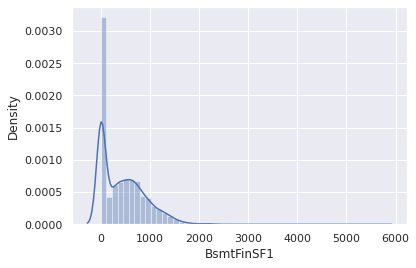

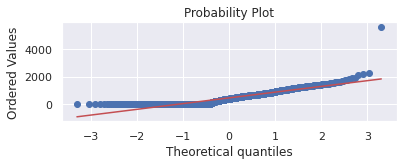

In [48]:
# BsmtFinSF1: Type 1 finished square feet
column = 'BsmtFinSF1'

all_data[column] = all_data[column].fillna(0)
sns.distplot(all_data[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)

print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")

Skewness: 1.426
Kurtosis: 6.904


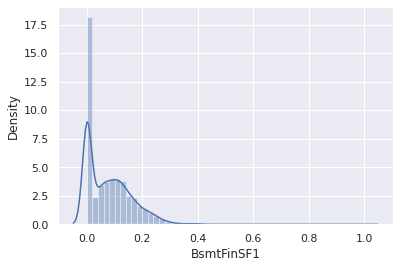

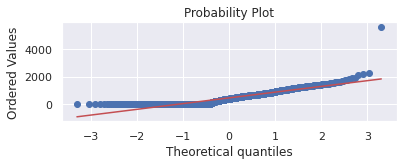

In [49]:
column = 'BsmtFinSF1'

# for these features with a large number of samples with value I favor min-max scaling
all_data[column] = (all_data[column] - all_data[column].min()) / (all_data[column].max() - all_data[column].min())
features = pd.concat([features,all_data[column]],axis=1)
sns.distplot(all_data[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)

print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")

In [50]:
# BsmtFinType2: Rating of basement finished area (if multiple types)

#        GLQ	Good Living Quarters
#        ALQ	Average Living Quarters
#        BLQ	Below Average Living Quarters	
#        Rec	Average Rec Room
#        LwQ	Low Quality
#        Unf	Unfinshed
#        NA	No Basement
column = 'BsmtFinType2'

all_data[column] = all_data[column].fillna('NA')
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


Skewness: 4.148
Kurtosis: 18.844


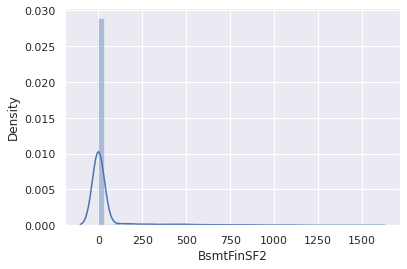

In [51]:
# BsmtFinSF2: Type 2 finished square feet
column = 'BsmtFinSF2'

all_data[column] = all_data[column].fillna(0)
sns.distplot(all_data[column])
print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")
# let's drop this feature here

Skewness: 0.920
Kurtosis: 0.404


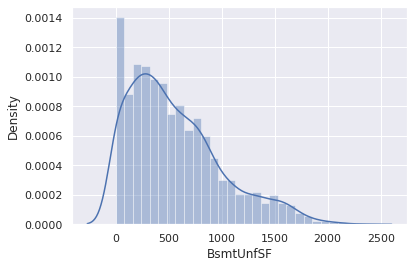

In [52]:
# BsmtUnfSF: Unfinished square feet of basement area
column = 'BsmtUnfSF'

all_data[column] = all_data[column].fillna(0)
sns.distplot(all_data[column])
print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")

0 incomplete values


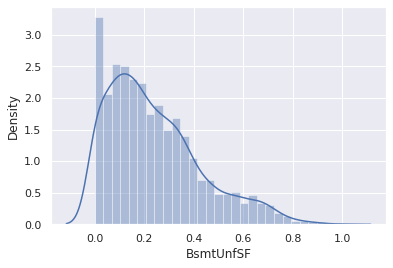

In [53]:
column = 'BsmtUnfSF'

all_data[column] = (all_data[column] - all_data[column].min()) / (all_data[column].max() - all_data[column].min())
features = pd.concat([features,all_data[column]],axis=1)
sns.distplot(all_data[column])
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

Skewness: 1.163
Kurtosis: 9.151


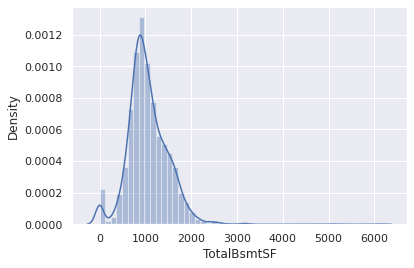

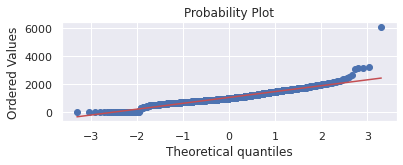

In [54]:
# TotalBsmtSF: Total square feet of basement area
column = 'TotalBsmtSF'

sns.distplot(all_data[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)
print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")

Skewness: 1.157
Kurtosis: 9.123
0 incomplete values


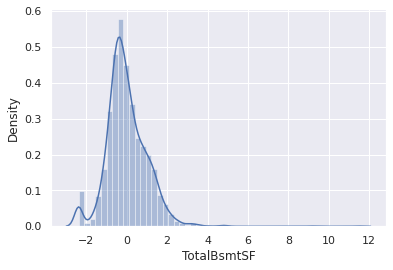

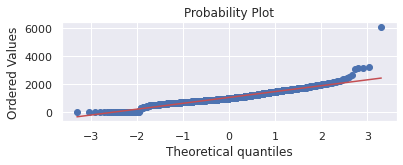

In [55]:
column = 'TotalBsmtSF'

all_data[column] = all_data[column].fillna(0)
scaler = preprocessing.StandardScaler().fit(all_data[[column]])
all_data[[column]] = scaler.transform(all_data[[column]])
features = pd.concat([features,all_data[column]],axis=1)

sns.distplot(all_data[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)

print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

In [56]:
# Heating: Type of heating
		
#        Floor	Floor Furnace
#        GasA	Gas forced warm air furnace
#        GasW	Gas hot water or steam heat
#        Grav	Gravity furnace	
#        OthW	Hot water or steam heat other than gas
#        Wall	Wall furnace
column = 'Heating'

# apply dummy values
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [57]:
# HeatingQC: Heating quality and condition

#        Ex	Excellent
#        Gd	Good
#        TA	Average/Typical
#        Fa	Fair
#        Po	Poor
column = 'HeatingQC'

# apply dummy values
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [58]:
# CentralAir: Central air conditioning

#        N	No
#        Y	Yes
column = 'CentralAir'

# apply dummy values
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [59]:
# Electrical: Electrical system

#        SBrkr	Standard Circuit Breakers & Romex
#        FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
#        FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
#        FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
#        Mix	Mixed
column = 'Electrical'

# apply dummy values
all_data[column] = all_data[column].fillna('SBrkr')
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


Skewness: 1.470
Kurtosis: 6.956


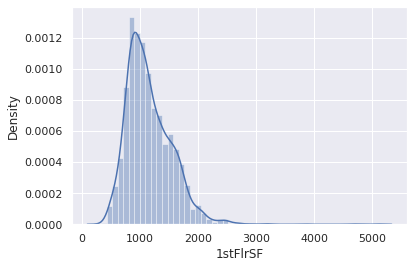

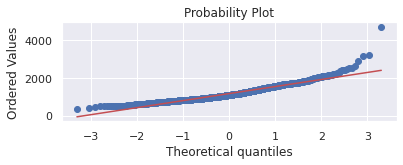

In [60]:
# 1stFlrSF: First Floor square feet
column = '1stFlrSF'

sns.distplot(all_data[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)
print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")

Skewness: -0.001
Kurtosis: 0.132
0 incomplete values


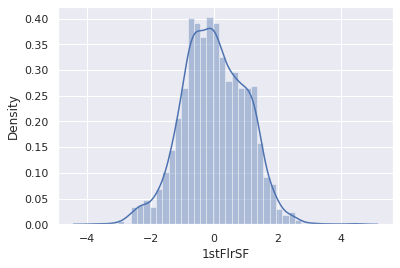

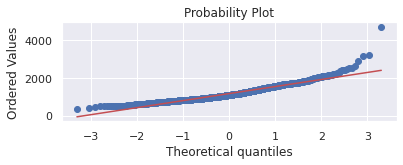

In [61]:
column = '1stFlrSF'

# box-cox to improve normaility
all_data[column], lamb = stats.boxcox(all_data[column])
scaler = preprocessing.StandardScaler().fit(all_data[[column]])
all_data[[column]] = scaler.transform(all_data[[column]])
features = pd.concat([features,all_data[column]],axis=1)

sns.distplot(all_data[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)

print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

Skewness: 0.862
Kurtosis: -0.422


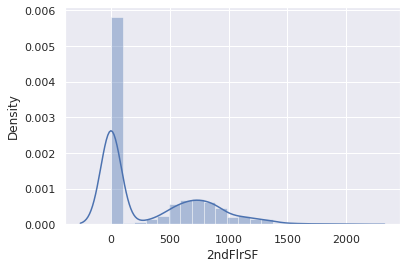

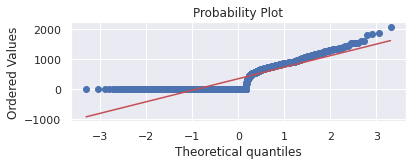

In [62]:
# 2ndFlrSF: Second floor square feet
column = '2ndFlrSF'

sns.distplot(all_data[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)
print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")

Skewness: 0.862
Kurtosis: -0.422


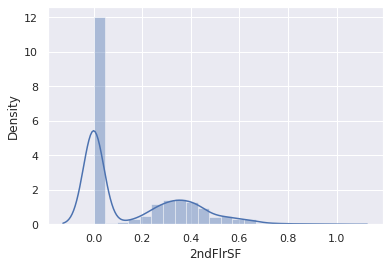

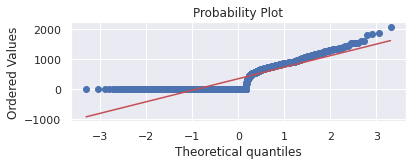

In [63]:
column = '2ndFlrSF'

#min-max scaling
all_data[column] = (all_data[column] - all_data[column].min()) / (all_data[column].max() - all_data[column].min())
features = pd.concat([features,all_data[column]],axis=1)
sns.distplot(all_data[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)
print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")

Skewness: 12.095
Kurtosis: 174.933


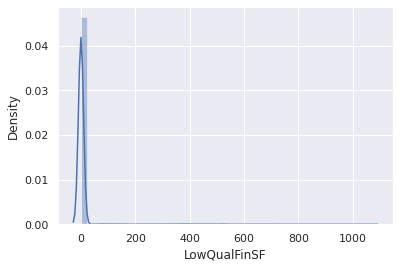

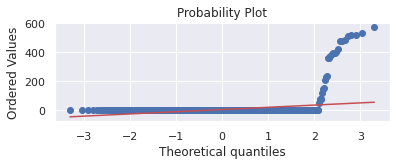

In [64]:
# LowQualFinSF: Low quality finished square feet (all floors)
column = 'LowQualFinSF'

sns.distplot(all_data[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)
print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")

Skewness: 8.370
Kurtosis: 68.108
0 incomplete values


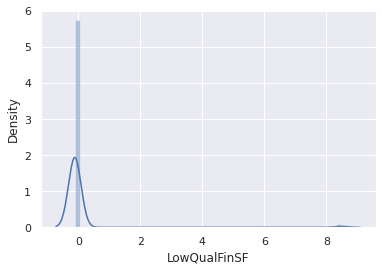

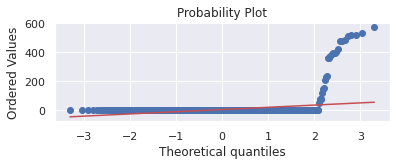

In [65]:
column = 'LowQualFinSF'

# box-cox to improve normaility
all_data[column] = all_data[column] + 0.1
all_data[column], lamb = stats.boxcox(all_data[column])
scaler = preprocessing.StandardScaler().fit(all_data[[column]])
all_data[[column]] = scaler.transform(all_data[[column]])
features = pd.concat([features,all_data[column]],axis=1)

sns.distplot(all_data[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)

print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

Skewness: 1.270
Kurtosis: 4.122


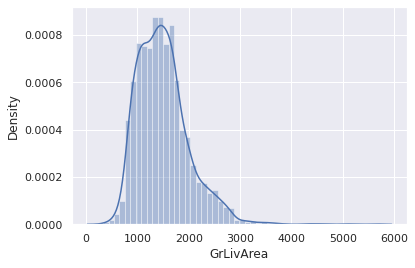

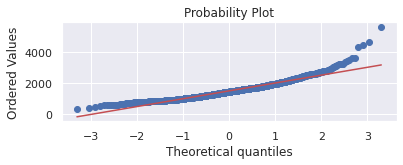

In [66]:
# GrLivArea: Above grade (ground) living area square feet
column = 'GrLivArea'

sns.distplot(all_data[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)
print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")

Skewness: -0.000
Kurtosis: 0.212
0 incomplete values


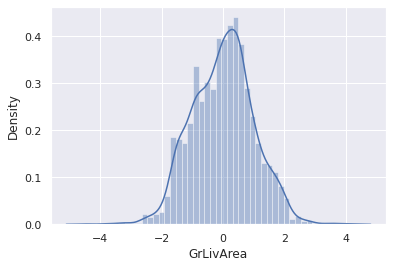

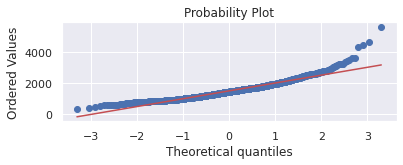

In [67]:
column = 'GrLivArea'

# box-cox to improve normaility
all_data[column] = all_data[column] + 0.1
all_data[column], lamb = stats.boxcox(all_data[column])
scaler = preprocessing.StandardScaler().fit(all_data[[column]])
all_data[[column]] = scaler.transform(all_data[[column]])
features = pd.concat([features,all_data[column]],axis=1)

sns.distplot(all_data[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)

print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

In [68]:
# BsmtFullBath: Basement full bathrooms
column = 'BsmtFullBath'

#let's use dummies
all_data[column] = all_data[column].fillna(0)
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [69]:
# BsmtHalfBath: Basement half bathrooms
column = 'BsmtHalfBath'

#let's use dummies
all_data[column] = all_data[column].fillna(0)
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [70]:
# FullBath: Full bathrooms above grade
column = 'FullBath'

#let's use dummies
all_data[column] = all_data[column].fillna(0)
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [71]:
# HalfBath: Half baths above grade
column = 'HalfBath'

#let's use dummies
all_data[column] = all_data[column].fillna(0)
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [72]:
#Bedroom: Bedrooms above grade (does NOT include basement bedrooms)
column = 'BedroomAbvGr'

#let's use dummies
all_data[column] = all_data[column].fillna(0)
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [73]:
# Kitchen: Kitchens above grade
column = 'KitchenAbvGr'

#let's use dummies
all_data[column] = all_data[column].fillna(0)
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [74]:
# KitchenQual: Kitchen quality

#        Ex	Excellent
#        Gd	Good
#        TA	Typical/Average
#        Fa	Fair
#        Po	Poor
column = 'KitchenQual'

#let's use dummies
all_data[column] = all_data[column].fillna('TA')
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


Skewness: 0.759
Kurtosis: 1.169


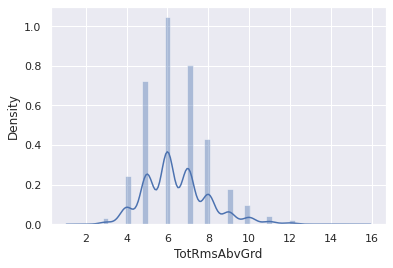

In [75]:
# TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
column = 'TotRmsAbvGrd'

sns.distplot(all_data[column])
print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")

Skewness: 0.003
Kurtosis: 0.363
0 incomplete values


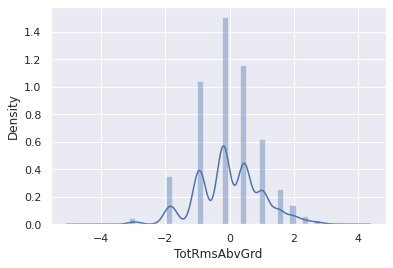

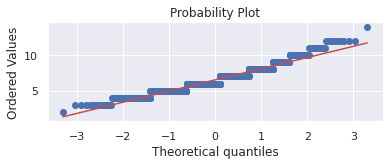

In [76]:
column = 'TotRmsAbvGrd'

# box-cox to improve normaility
all_data[column] = all_data[column] + 0.1
all_data[column], lamb = stats.boxcox(all_data[column])
scaler = preprocessing.StandardScaler().fit(all_data[[column]])
all_data[[column]] = scaler.transform(all_data[[column]])
features = pd.concat([features,all_data[column]],axis=1)

sns.distplot(all_data[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)

print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

In [77]:
# Functional: Home functionality (Assume typical unless deductions are warranted)

#        Typ	Typical Functionality
#        Min1	Minor Deductions 1
#        Min2	Minor Deductions 2
#        Mod	Moderate Deductions
#        Maj1	Major Deductions 1
#        Maj2	Major Deductions 2
#        Sev	Severely Damaged
#        Sal	Salvage only
column = 'Functional'

#let's use dummies
all_data[column] = all_data[column].fillna('Typ')
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [78]:
# Fireplaces: Number of fireplaces
column = 'Fireplaces'

#let's use dummies
all_data[column] = all_data[column].fillna('Typ')
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [79]:
# FireplaceQu: Fireplace quality

#        Ex	Excellent - Exceptional Masonry Fireplace
#        Gd	Good - Masonry Fireplace in main level
#        TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
#        Fa	Fair - Prefabricated Fireplace in basement
#        Po	Poor - Ben Franklin Stove
#        NA	No Fireplace
column = 'FireplaceQu'

#let's use dummies
all_data[column] = all_data[column].fillna('NA')
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [80]:
# GarageType: Garage location
		
#        2Types	More than one type of garage
#        Attchd	Attached to home
#        Basment	Basement Garage
#        BuiltIn	Built-In (Garage part of house - typically has room above garage)
#        CarPort	Car Port
#        Detchd	Detached from home
#        NA	No Garage
column = 'GarageType'

#let's use dummies
all_data[column] = all_data[column].fillna('NA')
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [81]:
# GarageYrBlt: Year garage was built
# column = 'GarageYrBlt'

# sns.distplot(all_data[column])
# print(f"Skewness: {all_data[column].skew():.3f}")
# print(f"Kurtosis: {all_data[column].kurt():.3f}")
# print('{0} incomplete values'.format(all_data[column].isnull().sum()))
# lets drop this feature here

In [82]:
# GarageFinish: Interior finish of the garage

#        Fin	Finished
#        RFn	Rough Finished	
#        Unf	Unfinished
#        NA	No Garage
column = 'GarageFinish'

#let's use dummies
all_data[column] = all_data[column].fillna('NA')
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


Skewness: -0.218
Kurtosis: 0.238
1 incomplete values


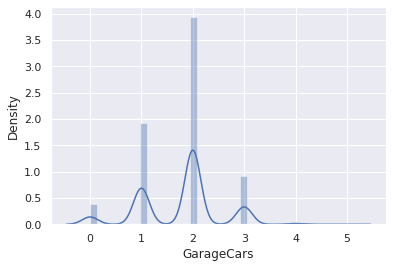

In [83]:
# GarageCars: Size of garage in car capacity
column = 'GarageCars'

sns.distplot(all_data[column])
print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

In [84]:
column = 'GarageCars'

#let's use dummies
all_data[column] = all_data[column].fillna('NA')
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


Skewness: 0.239
Kurtosis: 0.937
0 incomplete values


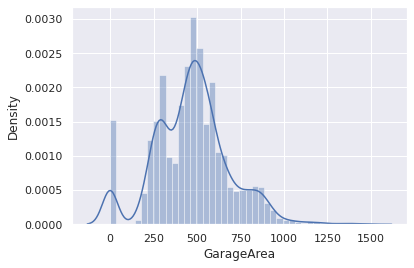

In [85]:
# GarageArea: Size of garage in square feet
column = 'GarageArea'


all_data[column] = all_data[column].fillna(0)
sns.distplot(all_data[column])
print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

Skewness: -0.537
Kurtosis: 1.332
0 incomplete values


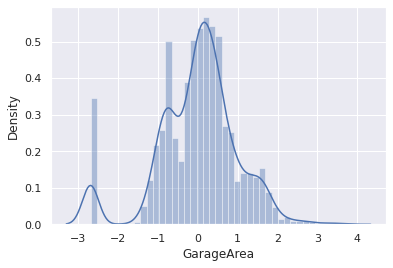

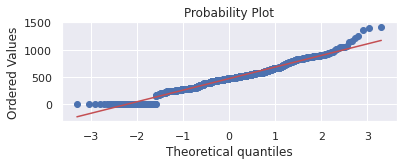

In [86]:
column = 'GarageArea'

# box-cox to improve normaility
all_data[column] = all_data[column] + 0.1
all_data[column], lamb = stats.boxcox(all_data[column])
scaler = preprocessing.StandardScaler().fit(all_data[[column]])
all_data[[column]] = scaler.transform(all_data[[column]])
features = pd.concat([features,all_data[column]],axis=1)

sns.distplot(all_data[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)

print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

In [87]:
# GarageQual: Garage quality

#        Ex	Excellent
#        Gd	Good
#        TA	Typical/Average
#        Fa	Fair
#        Po	Poor
#        NA	No Garage
column = 'GarageQual'

#let's use dummies
all_data[column] = all_data[column].fillna('NA')
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [88]:
# GarageCond: Garage condition

#        Ex	Excellent
#        Gd	Good
#        TA	Typical/Average
#        Fa	Fair
#        Po	Poor
#        NA	No Garage
column = 'GarageCond'

#let's use dummies
all_data[column] = all_data[column].fillna('NA')
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [89]:
# PavedDrive: Paved driveway

#        Y	Paved 
#        P	Partial Pavement
#        N	Dirt/Gravel
column = 'PavedDrive'

#let's use dummies
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


Skewness: 1.843
Kurtosis: 6.742


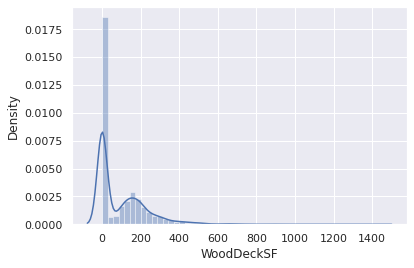

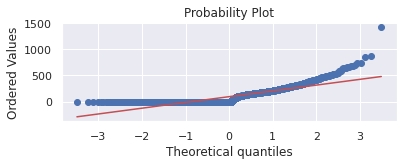

In [90]:
# WoodDeckSF: Wood deck area in square feet
column = 'WoodDeckSF'

sns.distplot(all_data[column])
fig = plt.figure()
ax2 = fig.add_subplot(212)
stats.probplot(all_data[column], dist=stats.norm, plot=ax2)
print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")

Skewness: 1.843
Kurtosis: 6.742


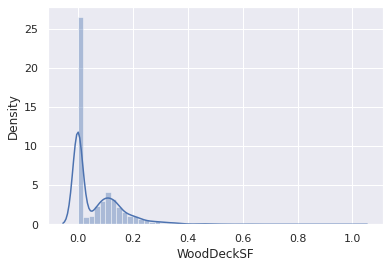

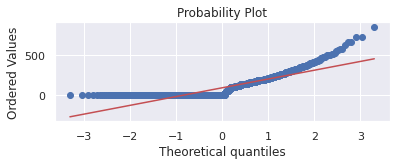

In [91]:
column = 'WoodDeckSF'

#min-max scaling
all_data[column] = (all_data[column] - all_data[column].min()) / (all_data[column].max() - all_data[column].min())
features = pd.concat([features,all_data[column]],axis=1)
sns.distplot(all_data[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)
print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")

Skewness: 2.536
Kurtosis: 10.937


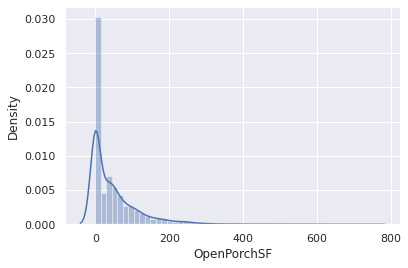

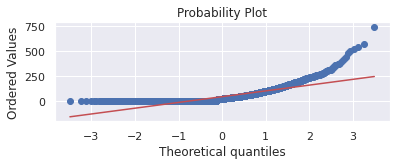

In [92]:
# OpenPorchSF: Open porch area in square feet
column = 'OpenPorchSF'

sns.distplot(all_data[column])
fig = plt.figure()
ax2 = fig.add_subplot(212)
stats.probplot(all_data[column], dist=stats.norm, plot=ax2)
print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")

Skewness: 2.536
Kurtosis: 10.937
0 incomplete values


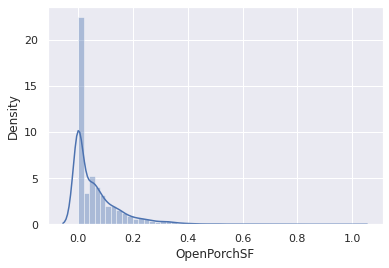

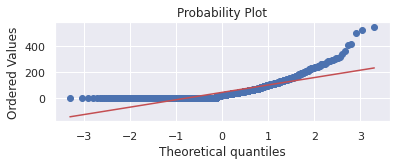

In [93]:
column = 'OpenPorchSF'

all_data[column] = all_data[column].fillna(0)
#min-max scaling
all_data[column] = (all_data[column] - all_data[column].min()) / (all_data[column].max() - all_data[column].min())
features = pd.concat([features,all_data[column]],axis=1)
sns.distplot(all_data[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)
print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

Skewness: 4.006
Kurtosis: 28.378


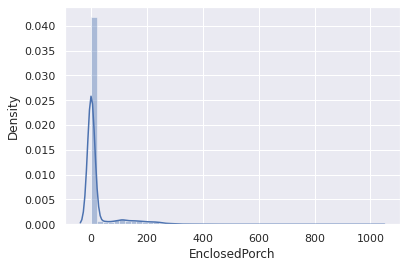

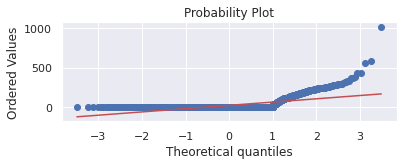

In [94]:
# EnclosedPorch: Enclosed porch area in square feet
column = 'EnclosedPorch'

sns.distplot(all_data[column])
fig = plt.figure()
ax2 = fig.add_subplot(212)
stats.probplot(all_data[column], dist=stats.norm, plot=ax2)
print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")

Skewness: 4.006
Kurtosis: 28.378
0 incomplete values


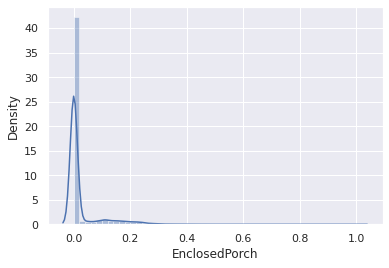

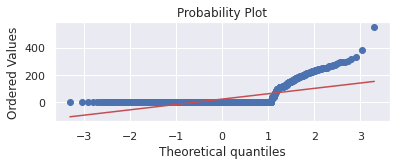

In [95]:
column = 'EnclosedPorch'

all_data[column] = all_data[column].fillna(0)
#min-max scaling
all_data[column] = (all_data[column] - all_data[column].min()) / (all_data[column].max() - all_data[column].min())
features = pd.concat([features,all_data[column]],axis=1)
sns.distplot(all_data[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)
print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

Skewness: 11.382
Kurtosis: 149.410


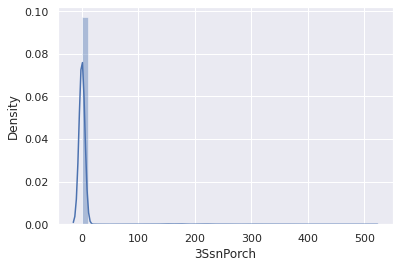

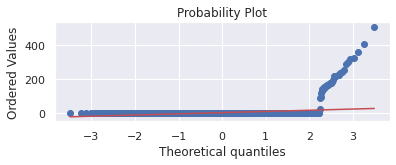

In [96]:
# 3SsnPorch: Three season porch area in square feet
column = '3SsnPorch'

sns.distplot(all_data[column])
fig = plt.figure()
ax2 = fig.add_subplot(212)
stats.probplot(all_data[column], dist=stats.norm, plot=ax2)
print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")

Skewness: 11.382
Kurtosis: 149.410
0 incomplete values


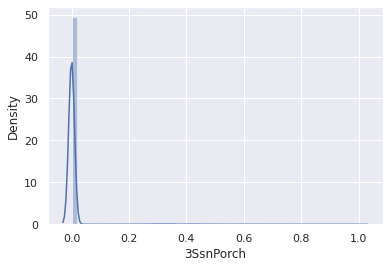

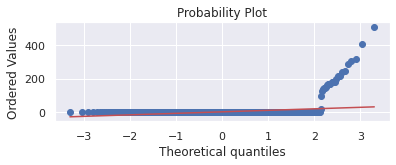

In [97]:
column = '3SsnPorch'


all_data[column] = all_data[column].fillna(0)
#min-max scaling
all_data[column] = (all_data[column] - all_data[column].min()) / (all_data[column].max() - all_data[column].min())
features = pd.concat([features,all_data[column]],axis=1)
sns.distplot(all_data[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)
print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

Skewness: 3.949
Kurtosis: 17.777


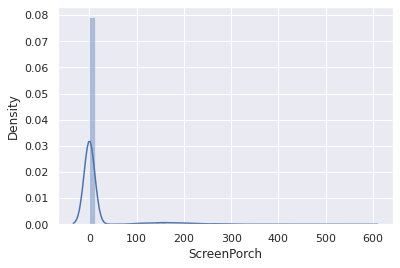

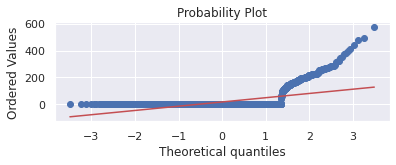

In [98]:
# ScreenPorch: Screen porch area in square feet
column = 'ScreenPorch'

sns.distplot(all_data[column])
fig = plt.figure()
ax2 = fig.add_subplot(212)
stats.probplot(all_data[column], dist=stats.norm, plot=ax2)
print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")

Skewness: 3.949
Kurtosis: 17.777
0 incomplete values


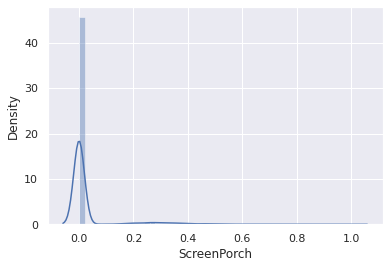

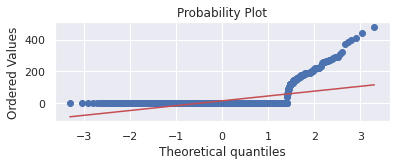

In [99]:
column = 'ScreenPorch'

all_data[column] = all_data[column].fillna(0)
#min-max scaling
all_data[column] = (all_data[column] - all_data[column].min()) / (all_data[column].max() - all_data[column].min())
features = pd.concat([features,all_data[column]],axis=1)
sns.distplot(all_data[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)
print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

Skewness: 16.907
Kurtosis: 298.633


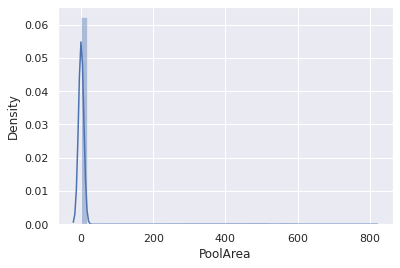

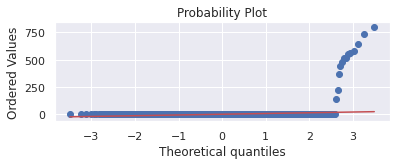

In [100]:
# PoolArea: Pool area in square feet
column = 'PoolArea'

sns.distplot(all_data[column])
fig = plt.figure()
ax2 = fig.add_subplot(212)
stats.probplot(all_data[column], dist=stats.norm, plot=ax2)
print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")

Skewness: 16.907
Kurtosis: 298.633
0 incomplete values


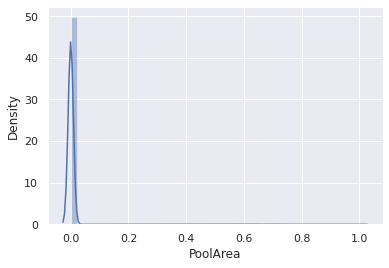

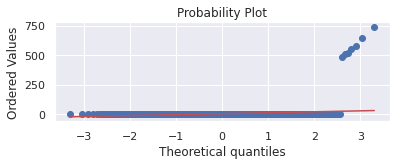

In [101]:
column = 'PoolArea'

all_data[column] = all_data[column].fillna(0)
#min-max scaling
all_data[column] = (all_data[column] - all_data[column].min()) / (all_data[column].max() - all_data[column].min())
features = pd.concat([features,all_data[column]],axis=1)
sns.distplot(all_data[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)
print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

In [102]:
# # PoolQC: Pool quality
		
# #        Ex	Excellent
# #        Gd	Good
# #        TA	Average/Typical
# #        Fa	Fair
# #        NA	No Pool
column = 'PoolQC'

all_data[column] = all_data[column].fillna('NA')
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [103]:
# Fence: Fence quality
		
#        GdPrv	Good Privacy
#        MnPrv	Minimum Privacy
#        GdWo	Good Wood
#        MnWw	Minimum Wood/Wire
#        NA	No Fence
column = 'Fence'

all_data[column] = all_data[column].fillna('NA')
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [104]:
# MiscFeature: Miscellaneous feature not covered in other categories
		
#        Elev	Elevator
#        Gar2	2nd Garage (if not described in garage section)
#        Othr	Other
#        Shed	Shed (over 100 SF)
#        TenC	Tennis Court
#        NA	None
column = 'MiscFeature'

all_data[column] = all_data[column].fillna('NA')
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [105]:
# # MiscVal: $Value of miscellaneous feature
# column = 'MiscVal'

# all_data[column] = all_data[column].map({'NA': 0})
# all_data[column] = all_data[column].fillna(0)
# if scale_type == 1:
#     scaler = preprocessing.StandardScaler().fit(all_data[[column]])
#     all_data[[column]] = scaler.transform(all_data[[column]])
#     features = pd.concat([features,all_data[column]],axis=1)
#     print('{0} incomplete values'.format(all_data[column].isnull().sum()))
# else:
#     ZoneStandardScalar(column)
#     all_data[column] = all_data[column].fillna(0)
#     features = pd.concat([features,all_data[column]],axis=1)
#     print('{0} incomplete values'.format(all_data[column].isnull().sum()))

In [106]:
# MoSold: Month Sold (MM)
column = 'MoSold'

dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


Skewness: 0.132
Kurtosis: -1.155


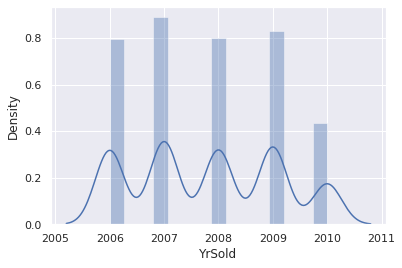

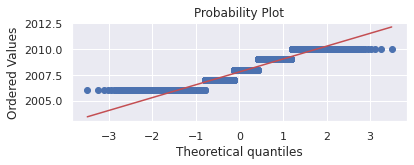

In [107]:
# YrSold: Year Sold (YYYY)
column = 'YrSold'

sns.distplot(all_data[column])
fig = plt.figure()
ax2 = fig.add_subplot(212)
stats.probplot(all_data[column], dist=stats.norm, plot=ax2)
print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")

Skewness: 0.132
Kurtosis: -1.155
0 incomplete values


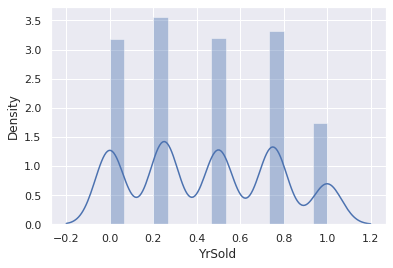

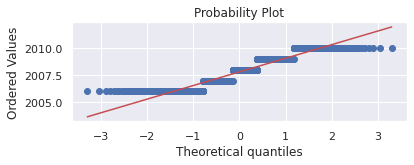

In [108]:
column = 'YrSold'

all_data[column] = all_data[column].fillna(0)
#min-max scaling
all_data[column] = (all_data[column] - all_data[column].min()) / (all_data[column].max() - all_data[column].min())
features = pd.concat([features,all_data[column]],axis=1)
sns.distplot(all_data[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)
print(f"Skewness: {all_data[column].skew():.3f}")
print(f"Kurtosis: {all_data[column].kurt():.3f}")
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

In [109]:
# # SaleType: Type of sale
		
#        WD 	Warranty Deed - Conventional
#        CWD	Warranty Deed - Cash
#        VWD	Warranty Deed - VA Loan
#        New	Home just constructed and sold
#        COD	Court Officer Deed/Estate
#        Con	Contract 15% Down payment regular terms
#        ConLw	Contract Low Down payment and low interest
#        ConLI	Contract Low Interest
#        ConLD	Contract Low Down
#        Oth	Other
column = 'SaleType'

all_data[column] = all_data[column].fillna('WD')
dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
features = pd.concat([features,dummies],axis=1)
print('{0} incomplete values'.format(all_data[column].isnull().sum()))

0 incomplete values


In [110]:
# # SaleCondition: Condition of sale

# #        Normal	Normal Sale
# #        Abnorml	Abnormal Sale -  trade, foreclosure, short sale
# #        AdjLand	Adjoining Land Purchase
# #        Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
# #        Family	Sale between family members
# #        Partial	Home was not completed when last assessed (associated with New Homes)
# column = 'SaleCondition'

# dummies = pd.get_dummies(all_data[column], columns=[column],prefix = column)
# features = pd.concat([features,dummies],axis=1)
# print('{0} incomplete values'.format(all_data[column].isnull().sum()))

In [111]:
X = features.iloc[:len(train),:]
X_test = features.iloc[len(train):,:]

In [ ]:
from sklearn.linear_model._bayes import ARDRegression
from sklearn.ensemble._weight_boosting import AdaBoostRegressor
from sklearn.linear_model._bayes import BayesianRidge
from sklearn.tree._classes import DecisionTreeRegressor 
from sklearn.linear_model._coordinate_descent import ElasticNetCV
from sklearn.ensemble._forest import ExtraTreesRegressor
from sklearn.gaussian_process._gpr import GaussianProcessRegressor
from sklearn.linear_model._glm.glm import GeneralizedLinearRegressor
from sklearn.ensemble._gb import GradientBoostingRegressor
from sklearn.ensemble._hist_gradient_boosting.gradient_boosting import HistGradientBoostingRegressor
from sklearn.linear_model._huber import HuberRegressor
from sklearn.isotonic import IsotonicRegression 
from sklearn.neighbors._regression import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model._least_angle import LarsCV
from sklearn.linear_model._coordinate_descent import LassoCV
from sklearn.linear_model._least_angle import LassoLarsCV
from sklearn.linear_model._least_angle import LassoLarsIC
from sklearn.linear_model._base import LinearRegression
from sklearn.svm._classes import LinearSVR
from sklearn.neural_network._multilayer_perceptron import MLPRegressor
from sklearn.svm._classes import NuSVR
from sklearn.linear_model._omp import OrthogonalMatchingPursuitCV
from sklearn.linear_model._passive_aggressive import PassiveAggressiveRegressor
from sklearn.neighbors._regression import RadiusNeighborsRegressor
from sklearn.ensemble._forest import RandomForestRegressor
from sklearn.linear_model._ridge import RidgeCV
from sklearn.linear_model._stochastic_gradient import SGDRegressor
from sklearn.svm._classes import SVR
from sklearn.linear_model._glm.glm import TweedieRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import KFold
from time import ctime

n_fold = 5
r2 = 0
predicted_prices = np.zeros(len(X_test))
cv = KFold(n_splits=n_fold, shuffle=True, random_state=420)

estimators = [('est0', TweedieRegressor(max_iter=10000)),
 ('est1', RandomForestRegressor()),
 ('est2', LinearSVR(max_iter=100000)),
 ('est3', SVR(max_iter=100000)),
 ('est4', DecisionTreeRegressor()),
 ('est5', RandomForestRegressor())]

festimator = LinearRegression()

model = StackingRegressor(estimators=estimators,final_estimator=festimator)

for fold_n, (train_index, valid_index) in enumerate(cv.split(X)):
    print('\nFold', fold_n, 'started at', ctime())

    X_train = X.iloc[train_index,:]
    X_valid = X.iloc[valid_index,:]
    
    Y_train = Y.iloc[train_index]
    Y_valid = Y.iloc[valid_index]
    
    model.fit(X_train,Y_train)
    r2 += model.score(X_valid,Y_valid)
    predicted_prices += model.predict(X_test)
        
r2 /= n_fold
predicted_prices /= n_fold
print(r2)


Fold 0 started at Thu Dec  3 15:18:05 2020

Fold 1 started at Thu Dec  3 15:18:51 2020

Fold 2 started at Thu Dec  3 15:19:41 2020

Fold 3 started at Thu Dec  3 15:20:31 2020

Fold 4 started at Thu Dec  3 15:21:25 2020


In [ ]:
predicted_prices = labels_scaler.inverse_transform(predicted_prices)
predicted_prices = special.inv_boxcox(predicted_prices, SalePrice_lamb) 
print(predicted_prices)

In [ ]:
submission = pd.DataFrame({
        "Id": test["Id"],
        "SalePrice": predicted_prices
    })

submission.to_csv('submission_4997.csv', index=False)